**Fortaleza**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import re
import numpy as np

from statistics import mean

In [2]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)
db = client.SpedDB
collection = db.tweets_brasil

In [3]:
city = 'Fortaleza'
df = pd.DataFrame.from_records(collection.find({'lang': {'$ne':'und'},'city':city,'score': {'$ne':None}, 'polarity': {'$ne':None}, '$or':[{'geo_source':'place'}, {'geo_source':'user_location'}]}, {'state':1,'city':1,'lang':1,'geo_source':1,'score':1,'created_at':1,'text':1,'polarity':1,'_id': 0}).sort('created_at'))

In [4]:
len(df)

8199

In [5]:
df.head()

,created_at,geo_source,state,city,text,score,lang,polarity
0,2020-02-01 10:08:44,user_location,Ceará,Fortaleza,RT @ABC: LOCKDOWN: Haunting drone footage show...,-0.4404,en,-0.589889
1,2020-02-02 03:12:20,user_location,Ceará,Fortaleza,RT @spectatorindex: BREAKING: First coronaviru...,-0.5994,en,-0.440800
2,2020-02-02 10:26:27,user_location,Ceará,Fortaleza,RT @spectatorindex: BREAKING: First coronaviru...,-0.5994,en,-0.440800
3,2020-02-02 11:16:39,user_location,Ceará,Fortaleza,RT @LeiaJaOnline: A notícia do falecimento foi...,-0.5994,pt,-0.066250
4,2020-02-02 12:14:23,user_location,Ceará,Fortaleza,RT @gazetadopovo: Primeira morte por coronavír...,-0.5994,pt,-0.568250


Média total de sentimentos - Vader

In [6]:
df['score'].describe()

count    8199.000000
mean       -0.052540
std         0.465952
min        -0.986000
25%        -0.440400
50%         0.000000
75%         0.318200
max         0.980900
Name: score, dtype: float64

Média total de sentimentos - SenticNet

In [7]:
df['polarity'].describe()

count    8199.000000
mean        0.157835
std         0.301036
min        -0.990000
25%        -0.014491
50%         0.159667
75%         0.348708
max         1.000000
Name: polarity, dtype: float64

Tweets por língua

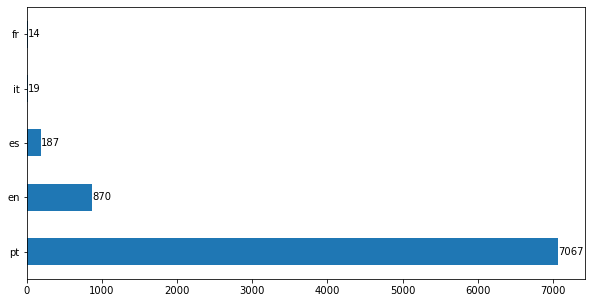

In [32]:
df.lang.value_counts()[:5].plot(kind='barh', figsize=(10, 5))

for index, value in enumerate(df.lang.value_counts()[:5]):
    plt.text(value, index, str(value), verticalalignment='center')

In [52]:
import nltk
from wordcloud import WordCloud, STOPWORDS

nltk.download('stopwords')

## função para geração de nuvens de palavras a partir de uma lista de strings
def generate_word_cloud(words_list, lower_case):
    
    if (len(words_list) > 0):   
        words=""

        # Criando string a partir das palavras        
        for word in words_list:
            if (lower_case):
                words = words + ' ' + word.lower()
            else:
                words = words + ' ' + word
                
        ## configurando stopwords para desconsiderar partículas verbais (exemplo: voltando-me)  
        stopwords = set(STOPWORDS)
        stopwords.update(nltk.corpus.stopwords.words('portuguese'))
        stopwords.update(['t','https','http','co','rt','...','pra','pro','vc','pq','q','contra','tudo','covid','corona','coronavirus','coronavírus','coronavíru','coronaviru','víru','viru'])
        
        wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(words)

        plt.figure(figsize=(8,4))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()

[nltk_data] Downloading package stopwords to /home/mario/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


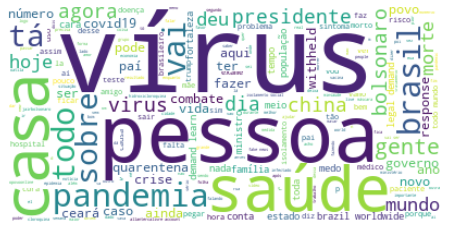

In [53]:
words = list(df['text'])
generate_word_cloud(words, True)

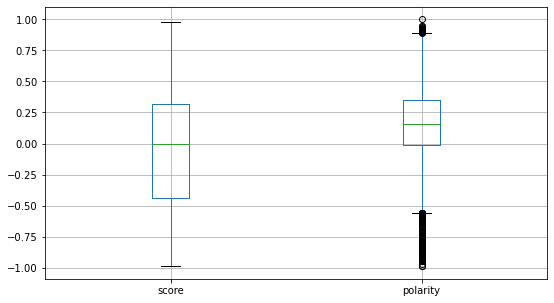

In [56]:
boxplot = df.boxplot(column=['score', 'polarity'], grid=True, figsize=(9, 5))

In [57]:
# Calculando coeficiente de correlação entre score e polarity (método de Pearson)
df['score'].corr(df['polarity'])

0.36497569506660704

Funções auxiliares

In [10]:
# Função para montar um df de Quantificadores por data a partir do df de Tweets
def building_dates_df(df, column):

    date_set = set()  
    
    for item in df.created_at:
        date = datetime.datetime(item.year, item.month, item.day)
        date_set.add(date)
    
    # Listas utilizadas para montagem do df
    date_list = list(date_set)
    date_list.sort()
    score_mean_list = []
        
    # Populando quantificadores para cada dia
    for index in date_list:
        # Média de scores do período
        score_mean = mean(df[column].loc[(df['created_at'].dt.year == index.year) & (df['created_at'].dt.month == index.month) & (df['created_at'].dt.day == index.day)])
        score_mean_list.append(score_mean)
    
    # Dicionário utilizado como parâmetro para a montagem
    data={'created_at': pd.Series(date_list), column + '_mean':pd.Series(score_mean_list)}
    
    # Criando df
    df = pd.DataFrame(data)
    
    return df 

In [11]:
# Função para geração de gráficos
def generate_graphic(x, y, label, color, xLabel, yLabel, title):
         
    plt.rcParams['figure.figsize'] = (18,5)
    plt.plot(x,y,color=color, linestyle='solid', linewidth=2,label=label)
    
    plt.xticks(x, rotation=80)
    plt.legend(fontsize=15)
    plt.xlabel(xLabel,fontsize=15)
    plt.ylabel(yLabel,fontsize=15)
    plt.title(title)
    plt.grid(True, linestyle='--')
    plt.show()

In [12]:
# Função para gerar um gráfico X outro
def generate_vs_graphic(x, y1, y2, label1, label2, color1, color2, xLabel, yLabel, title):
      
    plt.rcParams['figure.figsize'] = (18,5)
    plt.plot(x,y1,color=color1, linestyle='solid', linewidth=2,label=label1)
    plt.plot(x,y2,color=color2, linestyle='solid', linewidth=2,label=label2)

    plt.xticks(x, rotation=80)
    plt.legend(fontsize=15)
    plt.xlabel(xLabel,fontsize=15)
    plt.ylabel(yLabel,fontsize=15)
    plt.title(title)
    plt.grid(True, linestyle='--')
    plt.show()

In [13]:
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

Média de sentimentos por dia - Vader x SenticNet

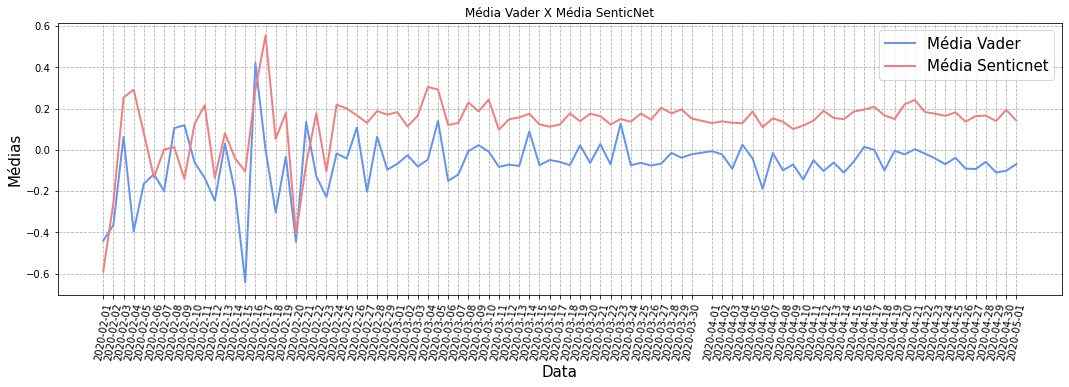

In [14]:
df1 = building_dates_df(df, 'score')
df2 = building_dates_df(df, 'polarity')

x = df1.created_at
y1 = df1.score_mean
y2 = df2.polarity_mean

label1 = 'Média Vader'
label2 = 'Média Senticnet'

color1 = 'cornflowerblue'
color2 = 'lightcoral'

xLabel = 'Data'
yLabel = 'Médias'

title = 'Média Vader X Média SenticNet'

generate_vs_graphic(x, y1, y2, label1, label2, color1, color2, xLabel, yLabel, title)

Análises por período

In [15]:
# Carregando arquivo CSV contendo casos de covid 19 do Brasil
file = '/home/mario/Documentos/LCDIA/Analytics/Datasets/caso_full.csv'
df_cases_brasil = pd.read_csv(file, usecols=['city', 'state', 'date', 'new_confirmed', 'new_deaths','last_available_confirmed','last_available_deaths','last_available_confirmed_per_100k_inhabitants','last_available_death_rate'])

In [16]:
# Selecionando casos da cidade analisada
df_cases_city = df_cases_brasil.query('city == "'+city+'"')
df_cases_city = df_cases_city.reset_index()
df_cases_city.head()

,index,city,date,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_death_rate,last_available_deaths,state,new_confirmed,new_deaths
0,284,Fortaleza,2020-03-16,8,0.29777,0.0,0,CE,8,0
1,345,Fortaleza,2020-03-17,9,0.33499,0.0,0,CE,1,0
2,417,Fortaleza,2020-03-18,17,0.63277,0.0,0,CE,8,0
3,513,Fortaleza,2020-03-19,17,0.63277,0.0,0,CE,0,0
4,630,Fortaleza,2020-03-20,63,2.34496,0.0,0,CE,46,0


In [17]:
# Data do primeiro caso 
first_case_date = df_cases_city.loc[0, 'date']
print(first_case_date)

2020-03-16


In [18]:
# Data da primeira morte
result = df_cases_city.query('last_available_deaths != "0"')
first_death_date = df_cases_city.loc[min(result.index), 'date']
print(first_death_date)

2020-03-26


Datas relevantes:

- Data do primeiro caso: 16/03/2020
- Data da primeira morte: 26/03/2020


- Data do primeiro decreto de medidas restritivas (Governador): 20/03/2020 a 29/03/2020
- Data da segundo decreto do medidas restritivas (Governador): 30/03/2020 a 05/04/2020
- Data da terceiro decreto do medidas restritivas (Governador): 06/04/2020 a 19/04/2020
- Data da quarto decreto do medidas restritivas (Governador): 20/04/2020 a 05/05/2020

**Análises - Datas de medidas restritivas - Antes e Depois a Primeira Medida**

**Média de sentimentos no primeiro intervalo (01/02/2020 a 19/03/2020)**

In [19]:
df1_periodo1 = df.query('created_at >= "2020-02-01 00:00:00" and created_at <= "2020-03-19 23:59:59"')
len(df1_periodo1)

1862

**Média de sentimentos no segundo intervalo (20/03/2020 a 01/05/2020)**

In [20]:
df1_periodo2 = df.query('created_at >= "2020-03-24 00:00:00" and created_at <= "2020-05-01 23:59:59"')
len(df1_periodo2)

5931

Gráfico - Média Valores

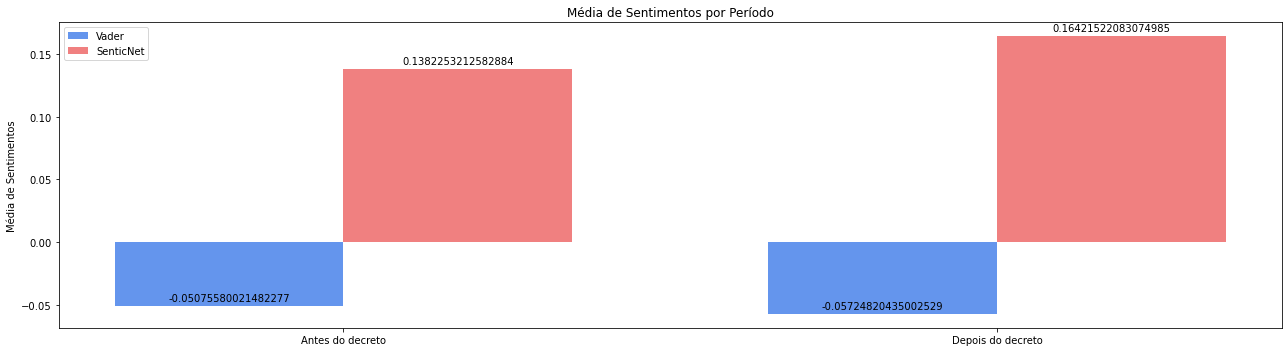

In [21]:
labels = ['Antes do decreto', 'Depois do decreto']
y1 = [mean(df1_periodo1['score']), mean(df1_periodo2['score'])]
y2 = [mean(df1_periodo1['polarity']), mean(df1_periodo2['polarity'])]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, y1, width, label='Vader', color='cornflowerblue')
rects2 = ax.bar(x + width/2, y2, width, label='SenticNet', color='lightcoral')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Média de Sentimentos')
ax.set_title('Média de Sentimentos por Período')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

**Análises - Datas de medidas restritivas - Por períodos de decretos**

**Média de sentimentos no primeiro intervalo (01/02/2020 a 19/03/2020)**

In [22]:
df1_periodo1 = df.query('created_at >= "2020-02-01 00:00:00" and created_at <= "2020-03-19 23:59:59"')
len(df1_periodo1)

1862

**Média de sentimentos no segundo intervalo (20/03/2020 a 29/03/2020)**

In [23]:
df1_periodo2 = df.query('created_at >= "2020-03-20 00:00:00" and created_at <= "2020-03-29 23:59:59"')
len(df1_periodo2)

1063

**Média de sentimentos no terceiro intervalo (30/03/2020 a 05/04/2020)**

In [24]:
df1_periodo3 = df.query('created_at >= "2020-03-30 00:00:00" and created_at <= "2020-04-05 23:59:59"')
len(df1_periodo3)

696

**Média de sentimentos no quarto intervalo (06/04/2020 a 19/04/2020)**

In [25]:
df1_periodo4 = df.query('created_at >= "2020-04-06 00:00:00" and created_at <= "2020-04-19 23:59:59"')
len(df1_periodo4)

2540

**Média de sentimentos no quinto intervalo (20/04/2020 a 01/05/2020)**

In [26]:
df1_periodo5 = df.query('created_at >= "2020-04-20 00:00:00" and created_at <= "2020-05-01 23:59:59"')
len(df1_periodo5)

2038

Gráfico - Média Valores

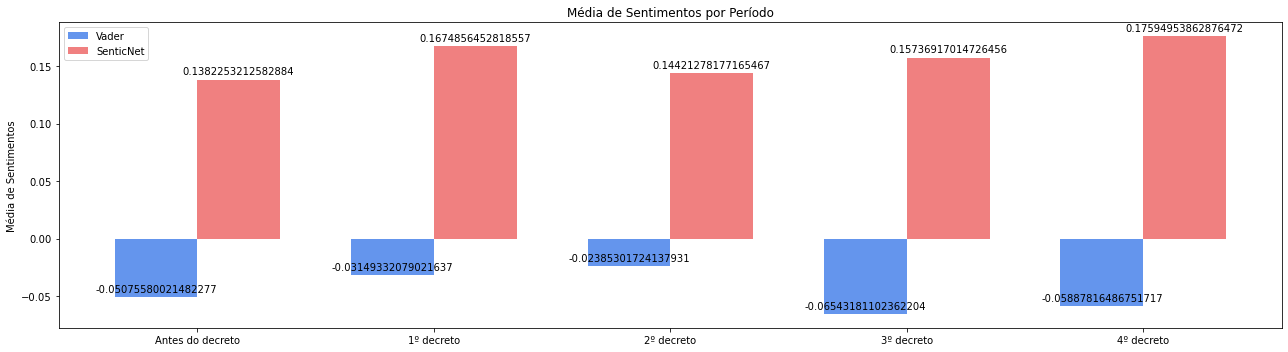

In [27]:
labels = ['Antes do decreto', '1º decreto', '2º decreto', '3º decreto', '4º decreto']
y1 = [mean(df1_periodo1['score']), mean(df1_periodo2['score']), mean(df1_periodo3['score']), mean(df1_periodo4['score']), mean(df1_periodo5['score'])]
y2 = [mean(df1_periodo1['polarity']), mean(df1_periodo2['polarity']), mean(df1_periodo3['polarity']), mean(df1_periodo4['polarity']), mean(df1_periodo5['polarity'])]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, y1, width, label='Vader', color='cornflowerblue')
rects2 = ax.bar(x + width/2, y2, width, label='SenticNet', color='lightcoral')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Média de Sentimentos')
ax.set_title('Média de Sentimentos por Período')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

**Análises - Marcos relevantes de casos**

**Média de sentimentos no primeiro intervalo (01/02/2020 a 15/03/2020)**

In [28]:
df2_periodo1 = df.query('created_at >= "2020-02-01 00:00:00" and created_at <= "2020-03-15 23:59:59"')
len(df2_periodo1)

1275

**Média de sentimentos no segundo intervalo (16/03/2020 a 25/03/2020)**

In [29]:
df2_periodo2 = df.query('created_at >= "2020-03-16 00:00:00" and created_at <= "2020-03-25 23:59:59"')
len(df2_periodo2)

1216

**Média de sentimentos no terceiro intervalo (26/03/2020 a 01/05/2020)**

In [30]:
df2_periodo3 = df.query('created_at >= "2020-03-26 00:00:00" and created_at <= "2020-05-01 23:59:59"')
len(df2_periodo3)

5708

Gráfico

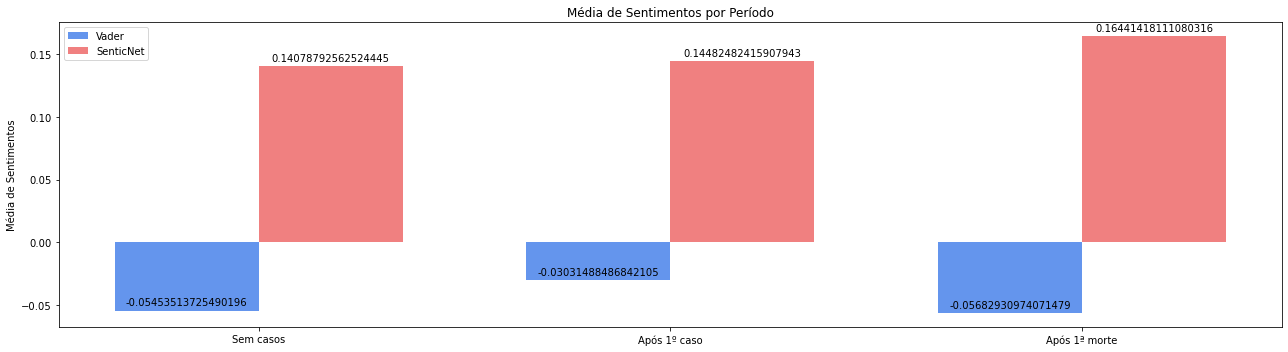

In [31]:
labels = ['Sem casos', 'Após 1º caso', 'Após 1ª morte']
y1 = [mean(df2_periodo1['score']), mean(df2_periodo2['score']), mean(df2_periodo3['score'])]
y2 = [mean(df2_periodo1['polarity']), mean(df2_periodo2['polarity']), mean(df2_periodo3['polarity'])]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, y1, width, label='Vader', color='cornflowerblue')
rects2 = ax.bar(x + width/2, y2, width, label='SenticNet', color='lightcoral')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Média de Sentimentos')
ax.set_title('Média de Sentimentos por Período')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

Fontes:
-  Decretos do Governo do Ceará com ações contra o coronavírus - https://www.ceara.gov.br/decretos-do-governo-do-ceara-com-acoes-contra-o-coronavirus/
- CoronaVírus - https://coronavirus.ceara.gov.br/project_tag/decreto/